# CAB420, DCNNs, Example 6: Fine Tuning and Data Augmentation
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
Deep networks need a lot of data to train. What can you do when you don't have much? This example will look at two approaches:
* Fine Tuning, where we adapt one network to some new data
* Data Augmentation, where we create addition data by subtling varying what we have

## Too Long; Didn't Read:
* Fine tuning will re-use a set of network weights for a new task. This can be seen simply as starting with a much more advanced set of weights over random initialistaion
* When we fine tune, we may wish to remove or change some layers. This may be because our new task has a different size output, or we've changed tasks entirely, going from for example classification to regression
* Data augmentation will dynamically create "new" data for us by applying transforms to the data that we already have.
* Care must be taken to ensure that the chosen transforms are reasonable. For example, for Fashion MNIST using random horizontal flips of the data doesn't change the meaning of the image (a mirror image of a shirt is usually still a shirt), but for MNIST, a flipped digit is no longer the same thing.
* Data augmentation does allow for training with much smaller datasets, and can also help prevent overfitting, even when using very large datasets, and as such this is a technique that is used more often than not in practice.

In [2]:
import numpy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



## A Base Model
We'll load a model from one of the "Lots of ..." examples. Becuase we saved the whole model, we can just load that and recover the architecture and weights.

We're going to load a model trained on MNIST. Is this important? Yeah, it's kind of a big deal. This means our "donor" model has a 28x28x1 input. While we can change the input size for a model, it's not easy, so we're now (probably) going to use this model with other data that's the same size.

The other thing that we'd like is to have some similarity between the data that the "donor" model is trained on, and what we're adapting it to. If there is more similarity, it means that the weights already learnt by the model will be more useful for our new task, i.e. it will be easier to adapt.

In [2]:
model = keras.models.load_model('../models/vgg_2stage_MNIST_small.h5')
model.summary()

Model: "simple_vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 8)         584       
                                                                 
 batch_normalization_17 (Bat  (None, 28, 28, 8)        32        
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 28, 28, 8)         0         
                                                                 
 spatial_dropout2d_10 (Spati  (None, 28, 28, 8)        0         
 alDropout2D)                                           

2022-01-11 05:35:23.613758: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-11 05:35:23.961176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6164 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5


## Fine Tuning: Task 1
### Some Data
It's Fashion MNIST, what else could it be!?

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255.0
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255.0
y_test = y_test.reshape(y_test.shape[0], 1)

### Fine Tuning
We now need to use this data to fine-tune the network. Let's do that.
In general, this is just like compiling and fitting a network as per usual, but there are a couple of things to note:
* Generally, we use a smaller learning rate for fine-tuning, the network is already trained after all, so we don't want to change our filters too much
* Often we'll avoid the fancier optimisers and just use SGD, as this will make small weight updates

Note that here, I'm not using a particular small learning rate, but have just switched optimisers. Why? So that I can train fast. Basically I'm taking the risk that I'll undo some of the good work of my earlier model so that I can get my data to fit quicker.

In [4]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.SGD(),#(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_test, y_test))

Epoch 1/10


2022-01-11 05:35:25.664398: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


469/469 [==============================] - 4s 5ms/step - loss: 1.7092 - accuracy: 0.6025 - val_loss: 0.7924 - val_accuracy: 0.7674
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 0.9105 - accuracy: 0.7274 - val_loss: 0.5828 - val_accuracy: 0.8072
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 0.7562 - accuracy: 0.7590 - val_loss: 0.5248 - val_accuracy: 0.8222
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.6768 - accuracy: 0.7776 - val_loss: 0.5245 - val_accuracy: 0.8216
Epoch 5/10
469/469 [==============================] - 3s 7ms/step - loss: 0.6229 - accuracy: 0.7931 - val_loss: 0.4682 - val_accuracy: 0.8342
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 0.5891 - accuracy: 0.8006 - val_loss: 0.4663 - val_accuracy: 0.8377
Epoch 7/10
469/469 [==============================] - 3s 7ms/step - loss: 0.5588 - accuracy: 0.8090 - val_loss: 0.4411 - val_accuracy: 0.8463
Epoch 8/10
469/46

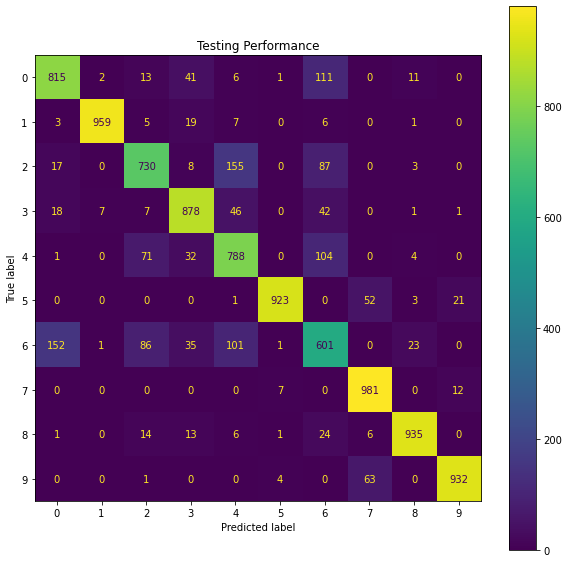

In [5]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
pred = model.predict(x_test);
indexes = tf.argmax(pred, axis=1)
cm = confusion_matrix(y_test, indexes)
c = ConfusionMatrixDisplay(cm, display_labels=range(10))
c.plot(ax = ax)    
ax.set_title('Testing Performance');

We can see that works ok, and I get some pretty reasonable results pretty quickly.

### Fine Tuning Only Some Layers
For very big networks (which we're not using), we don't really need to fine-tune everything - the early layers are probably pretty good and we likely don't have enough data to tweak them in a meaninful way for example. As such, we may want to restrict what we fine tune. We can do that really easily. 

In this case, we'll reload our weights and just tune up the last 5 layers. This is our two dense layers and the bit of stuff in between them.

In [6]:
model = keras.models.load_model('../models/vgg_2stage_MNIST_small.h5')

# Freeze the layers except the last 5 layers
for layer in model.layers[:-5]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f33a0147310> False
<keras.layers.convolutional.Conv2D object at 0x7f33a0147710> False
<keras.layers.convolutional.Conv2D object at 0x7f33a0147490> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f33a014b110> False
<keras.layers.core.activation.Activation object at 0x7f33a0147b10> False
<keras.layers.core.spatial_dropout.SpatialDropout2D object at 0x7f33ac150d90> False
<keras.layers.pooling.MaxPooling2D object at 0x7f33a01472d0> False
<keras.layers.convolutional.Conv2D object at 0x7f33a014bd90> False
<keras.layers.convolutional.Conv2D object at 0x7f33a01501d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f33a03cdd10> False
<keras.layers.core.activation.Activation object at 0x7f33ba2d1ed0> False
<keras.layers.core.spatial_dropout.SpatialDropout2D object at 0x7f33ac31abd0> False
<keras.layers.core.flatten.Flatten object at 0x7f33a0150d90> False
<keras.layers.cor

Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 3.4178 - accuracy: 0.4050 - val_loss: 1.1046 - val_accuracy: 0.6504
Epoch 2/20
469/469 [==============================] - 1s 3ms/step - loss: 1.3301 - accuracy: 0.6297 - val_loss: 0.8122 - val_accuracy: 0.7340
Epoch 3/20
469/469 [==============================] - 1s 3ms/step - loss: 1.0399 - accuracy: 0.6895 - val_loss: 0.7081 - val_accuracy: 0.7605
Epoch 4/20
469/469 [==============================] - 2s 3ms/step - loss: 0.8977 - accuracy: 0.7183 - val_loss: 0.6467 - val_accuracy: 0.7789
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.8124 - accuracy: 0.7374 - val_loss: 0.6100 - val_accuracy: 0.7884
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 0.7578 - accuracy: 0.7512 - val_loss: 0.5821 - val_accuracy: 0.7960
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.7125 - accuracy: 0.7617 - val_loss: 0.5617 - val_accuracy: 0.8051
Epoch 

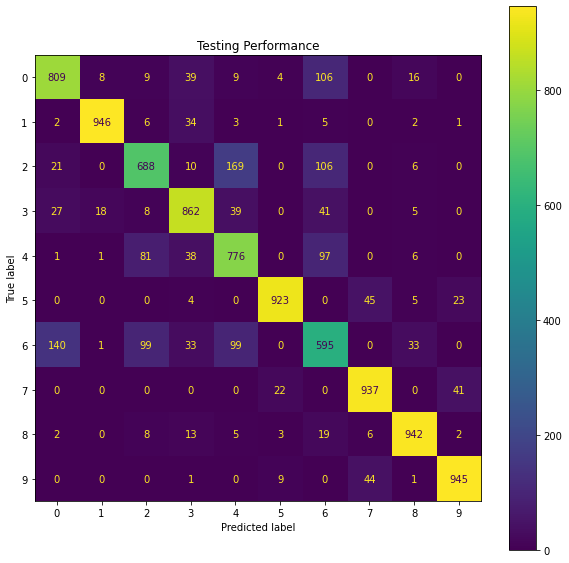

In [7]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.SGD(),#(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=128,
          epochs=20,
          validation_data=(x_test, y_test))

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
pred = model.predict(x_test);
indexes = tf.argmax(pred, axis=1)
cm = confusion_matrix(y_test, indexes)
c = ConfusionMatrixDisplay(cm, display_labels=range(10))
c.plot(ax = ax)    
ax.set_title('Testing Performance');

One thing that's immediately obvious with the second fine-tuning is that it's much quicker - we're now updating a lot fewer parameters, which makes the whole thing much faster. Accuracy is about the same (slightly lower here) - though this won't always be the case and does depend on how big the domain gap between the source and target data is.

## Fine Tuning: Task 2
### Some Data
It's rotated numbers! Does this warrant all this excitement in the text!? Not really!!

We'll "borrow" some code from an earlier example to get the data into it's rotated form.

In [8]:
def rotate(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background
    Source: http://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
    """
    # Get the image size
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(numpy.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = numpy.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = numpy.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (numpy.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (numpy.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (numpy.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (numpy.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = numpy.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (numpy.matrix(trans_mat) * numpy.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result

def rotate_dataset(input, rot_amount=45):

    out_x = numpy.zeros(input.shape, dtype='float32')
    out_y = numpy.zeros(input.shape[0], dtype='float32')

    for i,image in enumerate(input):

        # get a random angle
        rotation_angle = numpy.random.randint(low=-rot_amount, high=rot_amount)

        # rotate the image
        rotated_image = rotate(image, rotation_angle)

        # add dimension to account for the channels if the image is greyscale
        if rotated_image.ndim == 2:
            rotated_image = numpy.expand_dims(rotated_image, axis=2)

        rotated_image = cv2.resize(rotated_image, (image.shape[1], image.shape[0]))
        
        # store the image and label in their corresponding batches
        out_x[i] = rotated_image
        out_y[i] = rotation_angle       
    
    return out_x, out_y

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255    
x_train_rot, y_train_rot = rotate_dataset(x_train, 45)
x_train_rot = x_train_rot.reshape(x_train_rot.shape[0], 28, 28, 1).astype('float32')
x_test_rot, y_test_rot = rotate_dataset(x_test, 45)
x_test_rot = x_test_rot.reshape(x_test_rot.shape[0], 28, 28, 1).astype('float32')    

## The Model
We need to change the classification layers here, as we now have a different type of output. To do that we will load our model, and then use that to create a new network.

We'll grab the output of our flatten later, and pass that to a new dense layer, which we'll then pass to another dense layer as our output. We can then create a new model with the original model input, and the new model output.

In [9]:
model = keras.models.load_model('../models/vgg_2stage_MNIST_small.h5')

x = layers.Dense(64, activation='relu')(model.layers[-6].output)
# output layer, single value, as we only have 1 output - the 
outputs = layers.Dense(1)(x)

new_model = keras.Model(inputs=model.input, outputs=outputs)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 8)         584       
                                                                 
 batch_normalization_17 (Bat  (None, 28, 28, 8)        32        
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 28, 28, 8)         0         
                                                                 
 spatial_dropout2d_10 (Spati  (None, 28, 28, 8)        0         
 alDropout2D)                                                

We'll then also set our network such that the existing layers are locked, i.e. we'll only train our two new layers.

In [10]:
# Freeze the layers except the last 2 layers, which we just added
for layer in new_model.layers[:-2]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in new_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f333c6c92d0> False
<keras.layers.convolutional.Conv2D object at 0x7f333c6c97d0> False
<keras.layers.convolutional.Conv2D object at 0x7f333c6c9550> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f333c6d1250> False
<keras.layers.core.activation.Activation object at 0x7f333c6d1910> False
<keras.layers.core.spatial_dropout.SpatialDropout2D object at 0x7f333c6d1a10> False
<keras.layers.pooling.MaxPooling2D object at 0x7f333c6c9290> False
<keras.layers.convolutional.Conv2D object at 0x7f333c6cc110> False
<keras.layers.convolutional.Conv2D object at 0x7f333c6c9c10> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f333c6cc4d0> False
<keras.layers.core.activation.Activation object at 0x7f333c6ccb90> False
<keras.layers.core.spatial_dropout.SpatialDropout2D object at 0x7f333c6d5990> False
<keras.layers.core.flatten.Flatten object at 0x7f333c6ccfd0> False
<keras.layers.cor

Model training, and some evaluation and visualisation, is then almost exactly as per the previous example using this data. We're now just training fewer layers and relying on stuff we learnt earlier.

In [11]:
# train the model
new_model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9))

history = new_model.fit(x_train_rot, y_train_rot,
                    batch_size=128,
                    epochs=20,
                    validation_data=(x_test_rot, y_test_rot))

Epoch 1/20
469/469 [==============================] - 2s 3ms/step - loss: 184.8961 - val_loss: 120.6623
Epoch 2/20
469/469 [==============================] - 2s 3ms/step - loss: 134.9458 - val_loss: 98.1558
Epoch 3/20
469/469 [==============================] - 1s 3ms/step - loss: 119.4949 - val_loss: 91.5944
Epoch 4/20
469/469 [==============================] - 1s 3ms/step - loss: 111.9446 - val_loss: 100.3364
Epoch 5/20
469/469 [==============================] - 2s 3ms/step - loss: 107.1235 - val_loss: 85.6111
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 107.0981 - val_loss: 97.4343
Epoch 7/20
469/469 [==============================] - 2s 5ms/step - loss: 103.2800 - val_loss: 88.4287
Epoch 8/20
469/469 [==============================] - 2s 4ms/step - loss: 102.1146 - val_loss: 89.3605
Epoch 9/20
469/469 [==============================] - 2s 4ms/step - loss: 97.7802 - val_loss: 82.7504
Epoch 10/20
469/469 [==============================] - 2s 4ms/step - los

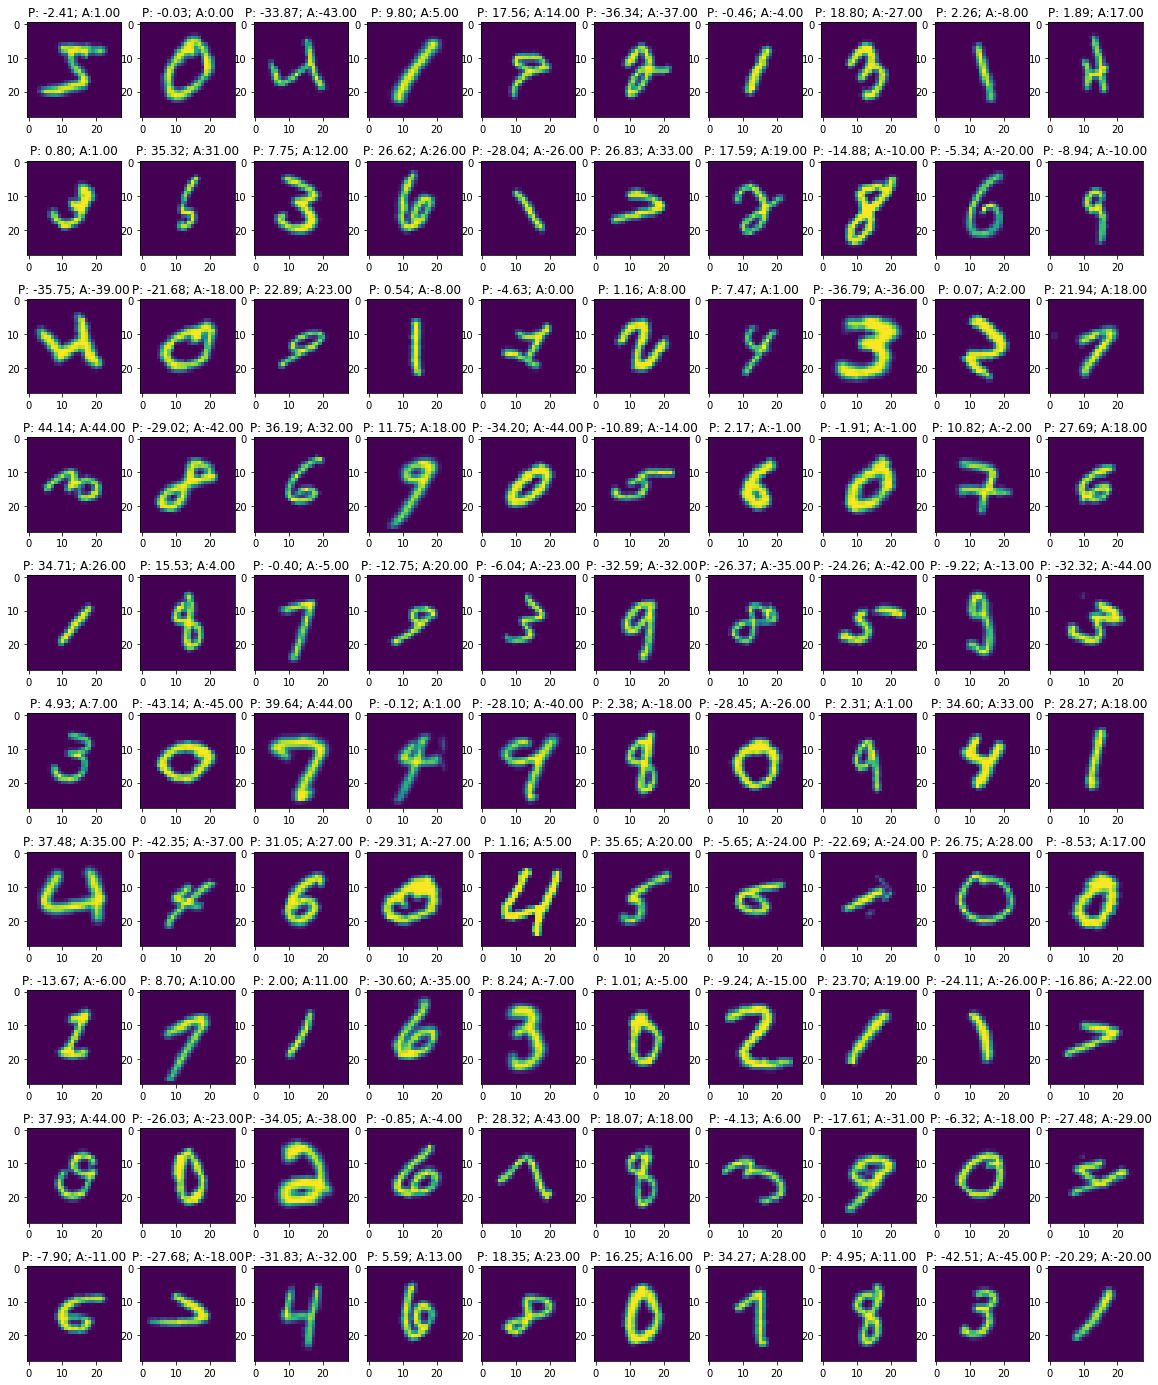

In [12]:
predictions = new_model.predict(x_test_rot)
fig = plt.figure(figsize=[20, 25])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(x_train_rot[i, :, :, 0])
    ax.set_title('P: ' + '%1.2f' % predictions[i] + '; A:' + '%1.2f' % y_test_rot[i])

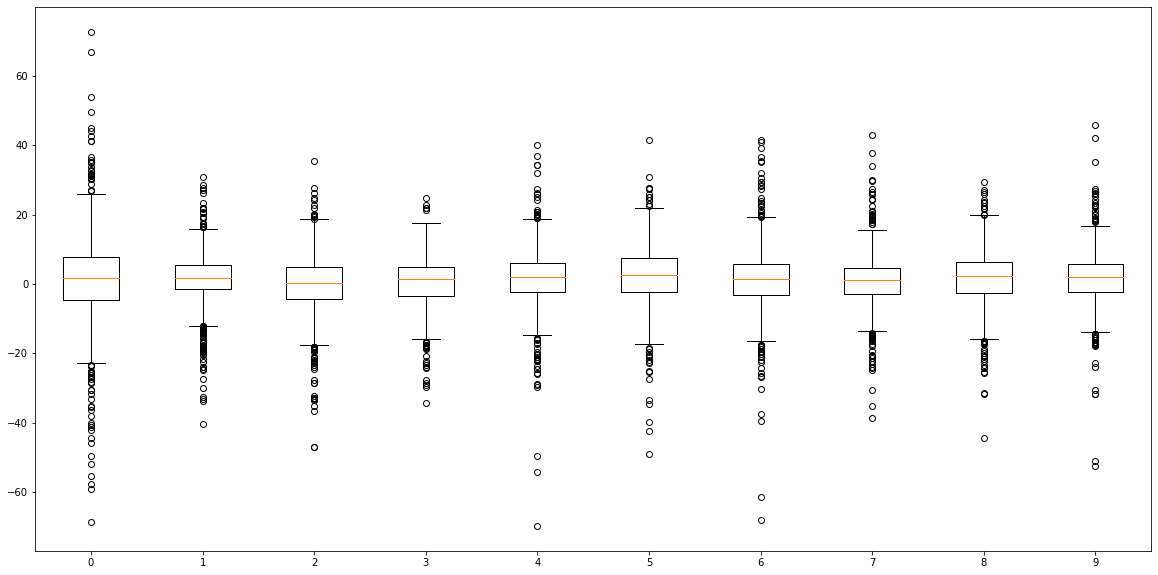

In [13]:
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(1, 1, 1)
data = []
labels = []
for i in range(10):
    sample_idx = numpy.array(y_test == i)
    errors = numpy.subtract(predictions[sample_idx, 0], y_test_rot[sample_idx])
    data.append(errors)
    labels.append(str(i))
    
ax.boxplot(data, labels=labels);

Again, we see this works pretty well and we can get good results quickly.

Here, the domain gap between our original model and our new model is really small, which helps a lot. Our original model is trained on MNIST, and our new task is also on the same MNIST data, just rotated. This means that it's really easy for our network to adapt to the new task.

## Data Augmentation

Deep networks need lots of data. It's one of the more annoying things about them. Collecting data is very painful, and is one of the more annoying things about machine learning. Data augmentation is a partial solution to both these annoyances.

The basic idea of data augmentation is to make new data by subtlely changing data you already have. These subtle changes can include:
* Random shifts of the image by small amounts
* Random rotations, or crops of the image
* The addition of noise, or other small colour shifts
* Rescaling of the image

Most deep learing toolkits have data augmentation tools available, though they all vary slightly in terms of what augmentations they allow. For any augmentation you use, you also need to be careful that it doesn't change the corresponding ground truth. 

If we consider an augmentation such as a slight image rotation, this makes no difference if we performing a classification task on MNIST. But if the task is to recover the angle that a digit as been rotated by (as we did above), than adding an extra rotation changes the ground truth for the sample. As such, in this case the augmentation should either be avoided, or be incorporated into the updated data.

### The Data
Let's mix it up and use something different. We'll go with Fashion MNIST.

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255.0
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255.0
y_test = y_test.reshape(y_test.shape[0], 1)

# remove 95% of the data, just take every 20th element
x_train = x_train[1::20, :, :, :]
print(numpy.shape(x_train))
y_train = y_train[1::20, :]
print(numpy.shape(y_train))

4423680/4422102 [==============================] - 3s 1us/step
(3000, 28, 28, 1)
(3000, 1)


### A Baseline
Let's setup a baseline. We'll fine-tune our network with the reduced Fashion MNIST and see what happens.

We'll do this as we did back at the start, fine-tune the whole network with SGD. Note that I've set the number of epochs to quite a large number, there are two reasons for this:
* I now have $\frac{1}{20}$th the data, so I need to increase my number of epochs by a factor of 20 to get the same number of training iterations as I would usually have
* I want to show what happens with limited training data and overfitting vs using augmentation. That's easier to show with lots of epochs

As such, I need to increase the number of epochs, but not by as much as I have. The extra increase is for demonstration purposes only.

In [15]:
model = keras.models.load_model('../models/vgg_2stage_MNIST_small.h5')
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.SGD(),#(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=1000,
          validation_data=(x_test, y_test),
          verbose=False)

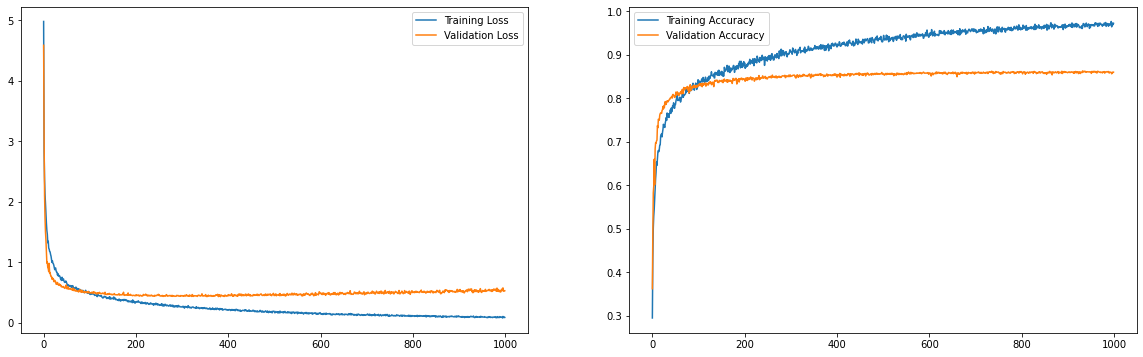

In [16]:
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label="Training Loss")
ax.plot(history.history['val_loss'], label="Validation Loss")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label="Training Accuracy")
ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
ax.legend()

What we see is that the model has started to overfit. We haven't got to the point where validation accuracy is dropping, but we've maxed out our performance.

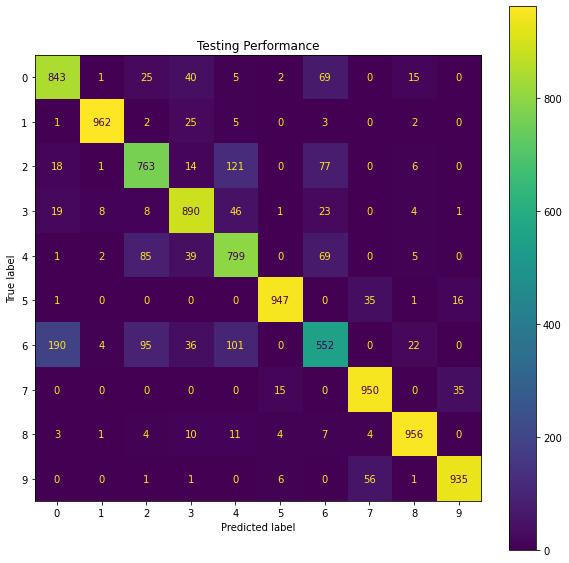

In [17]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
pred = model.predict(x_test);
indexes = tf.argmax(pred, axis=1)
cm = confusion_matrix(y_test, indexes)
c = ConfusionMatrixDisplay(cm, display_labels=range(10))
c.plot(ax = ax)    
ax.set_title('Testing Performance');

### With Data Augmentation
Let's rinse and repeat now using some data augmentation.

There are a lot of data augmentation options with Keras, and we won't go into all of them here, but the help does a pretty good job of listing what can be done [here](https://www.tensorflow.org/tutorials/images/data_augmentation) and [here](https://keras.io/guides/preprocessing_layers/).

We'll keep it pretty simple, and include:
* random horizontal flips
* small rotations
* small scale changes
* small translations

We should always visualise our augmentation, so we'll take 10 images, and augment each of them 10 times to get a sense of the variation that's possible.

In [12]:
print(x_train[10,:,:,:].shape)
print(tf.expand_dims(x_train[i+10,:,:,:],0).shape)
data_augmentation(tf.expand_dims(x_train[i+10,:,:,:],0)).shape

(28, 28, 1)
(1, 28, 28, 1)


TensorShape([1, 28, 28, 1])

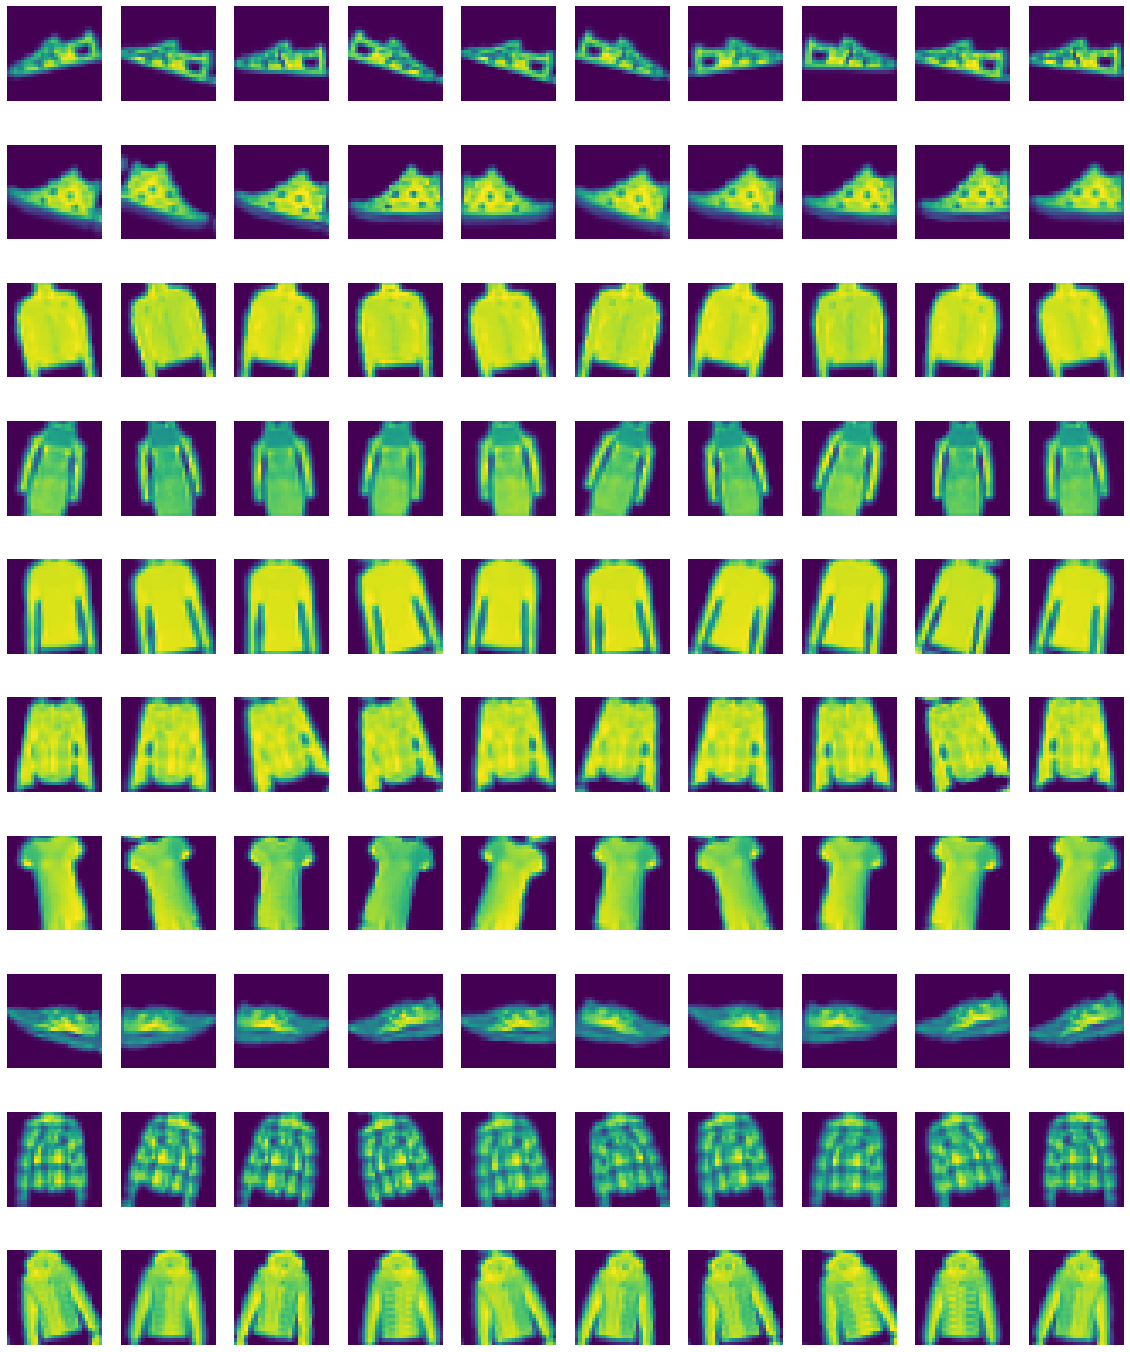

In [6]:
data_augmentation = keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.05),
  layers.experimental.preprocessing.RandomZoom(0.025),
  layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.025, 0.025), width_factor=(-0.025, 0.025))
])

fig = plt.figure(figsize=[20, 25])
for i in range(10):
    for j in range(10):
        ax = fig.add_subplot(10, 10, i*10 + (j + 1))
        augmented_image = data_augmentation(tf.expand_dims(x_train[i+10,:,:,:],0))
        plt.imshow(augmented_image[0])
        plt.axis("off")

We can see from the above that we have a fair bit more variation in the data. With our transforms we're at the point where the actual object is, in some cases, starting to get pushed just beyond the edge of the object bounds, so we need to be careful to not push this too much further.

To use this in our model, we have a couple of options:
* We can wrap our data up in a tensorflow dataset object
* We can include our augmentation directly in the model

We'll do the second, as it's far simpler. To make this work, we need to:
* remove the input layer from our old model
* create a new input layer, which we'll pass to our augmentation
* pass the output of the augmentation to the rest of the model

We can do this using the following:

In [19]:
# load model
model = keras.models.load_model('../models/vgg_2stage_MNIST_small.h5')
# remove first layer, i.e. the input
model.layers.pop(0)
# create a new input
input_layer = keras.Input(shape=(28, 28, 1, ), name='img')
# pass the input to our augmenter
augmented = data_augmentation(input_layer)
# pass the augmented input to the rest of the model
output = model(augmented)

At this point, we can create our model as we normally would, and everything from the augmentation layer down is the model that we loaded from disk.

In [20]:
new_model = keras.Model(inputs=input_layer, outputs=output)
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         0         
                                                                 
 simple_vgg (Functional)     (None, 10)                810914    
                                                                 
Total params: 810,914
Trainable params: 810,354
Non-trainable params: 560
_________________________________________________________________


At this point, it proceeds as normal in terms of model compiling and training.

In [21]:
new_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.SGD(),#(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
history = new_model.fit(x_train, y_train, batch_size=128,
                    epochs=1000,
                    validation_data=(x_test, y_test), verbose=False)

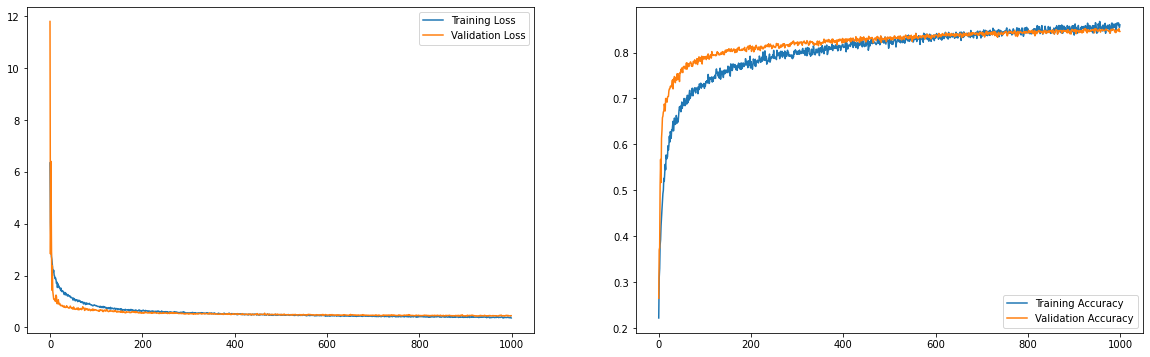

In [22]:
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label="Training Loss")
ax.plot(history.history['val_loss'], label="Validation Loss")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label="Training Accuracy")
ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
ax.legend()

Running for the same period of time as last time, we see that we don't overfit. Our validation accuracy is above what we had before, but our training accuracy is well below. Basically, we've helped our model generalise by artificially increasing variation in the data.

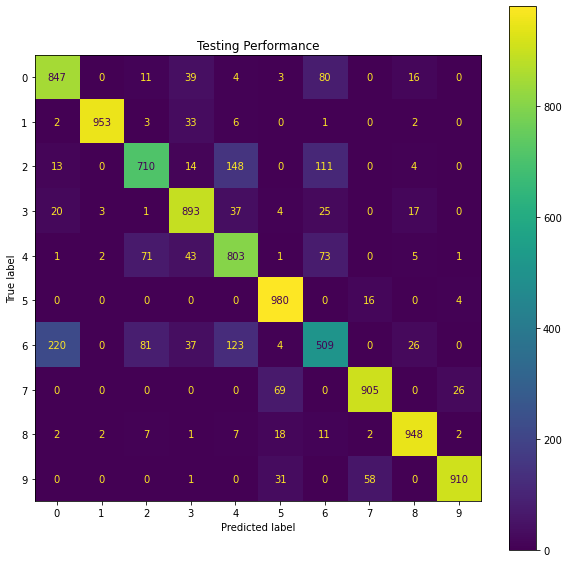

In [23]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
pred = model.predict(x_test);
indexes = tf.argmax(pred, axis=1)
cm = confusion_matrix(y_test, indexes)
c = ConfusionMatrixDisplay(cm, display_labels=range(10))
c.plot(ax = ax)    
ax.set_title('Testing Performance');

We see that with the augmented data, we get much better performance and the model doesn't overfit to the same extent.

## Final Thoughts

In this example we've had a play with fine-tuning and data augmentation.

Fine tuning can be seen as a form of advanced initialisation. Rather than initialise our network with random weights, we instead initialise it with weights learned on a (hopefully) related task. The hope is that several layers of the network, in particular with CNNs the convoluation layers that learn filters, will work well for the new task, and so the network can very quickly become accurate on the new data. For this to work well, ideally the two sets of data (the data the network was originally trained on and the data we are fine tuning with) should be from similar domains, i.e. natural colour images.

Often when fine tuning, there will be a need to replace some layers, particulary for the network output, to adapt the network to the new task. This means that these new layers will start from random initialisations, while the rest of the network is initialised with the previously learned weights. In some cases, in particular where the network is very large, the tasks are quite similar, or data is very limited, a number of layers may be frozen such their weights are not trained at all. This can be particularly useful with deep DCNNs, where the early convolutional layers that learn basic image primitives that typically translate very well across datasets can be frozen to further reduce training effort.

Data augmentation offers a way to get more from limited data. While this can be really powerful, care must be taken to ensure that generated data is still realistic and that it doesn't in some way alter what the ground truth should be. The simplest way to help ensure this is just to inspect the data, and check that your transform is doing what you expect.